# Capstone Project- The Battle of the Neighborhoods (Week 2)

### Data Science Capstone through IBM/Coursera

## Influence of Venue Types on International Tourism in United States Cities


## Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

This project will attempt to determine the **types of venues** that **promote international tourism** among top tourist destinations **in the United States**. Using international tourism data and venue location data by cities, the types of venues that are most popular among cities with high international tourism rates will be determined.

The types of venues that attract the most international tourism will be presented to state and federal legislators to provide an idea as to which type of attractions can boost international tourism rates. This information can help government revenues and local economies, provide employment, and benefit conservation of habitats and historic sites.

## Data <a name="data"></a>

The type of data needed to solve this problem includes the following:
* Number of international tourists per city in the United States
* Types of venues located among the most popular tourism cities in the United States
* Popularity of each venue within each city

Data sources and required information:
* International tourist data will be obtained from **Travel Trade** 
    * This data includes the **top 61** cities in the United States by estimation of overseas visitors in 2017 and 2018
* The center of each city will be acquired using **Google Maps API geocoding**
* The type and frequency of venues within each city will be found using the **Foursquare API**


This data will provide a list of venues to legislators that will increase international tourism for United States cities.


#### 61 Most Popular Cities by International Tourism

The following code acquires the major international tourism destinations and average visitations per year within the United States by their Metropolitan Statistical Area (MSA).

In [148]:
#import the required libraries
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print("Libraries installed!")

Libraries installed!


In [4]:
url = "https://travel.trade.gov/outreachpages/download_data_table/US%20cities%20Visited%202018.xlsx"
travel_city = pd.read_excel(url)
travel_city = travel_city.drop(columns =['Unnamed: 0', 'Unnamed: 4']).iloc[4:].rename(columns={"Unnamed: 1":"City", "Unnamed: 2":"2018 Percentage", "Unnamed: 3":"2018 Total Visitors", "Unnamed: 5":"2017 Percentage", "Unnamed: 6":"2017 Total Visitors"}).reset_index(drop = True)
travel_city.dropna(axis = 0, how= "any", inplace = True)
travel_city["Avg Per Year"] = travel_city[["2018 Total Visitors", "2017 Total Visitors"]].mean(axis=1)
travel_city.head()

,City,2018 Percentage,2018 Total Visitors,2017 Percentage,2017 Total Visitors,Avg Per Year
0,"New York-White Plains-Wayne, NY-NJ",0.2647,10557,0.2592,10084,10320.5
1,"Miami-Miami Beach-Kendall, FL",0.1288,5137,0.1311,5101,5119.0
2,"Los Angeles-Long Beach-Glendale, CA",0.1272,5073,0.1225,4766,4919.5
3,"Orlando-Kissimmee-Sanford, FL",0.1091,4351,0.1196,4653,4502.0
4,"San Francisco-San Mateo-Redwood City, CA",0.0883,3522,0.0885,3443,3482.5


The Metropolitan Statistical Area (MSA) locations were condensend to one city (below) with the assumption that the first city/state listed accounts for the larger portion of tourism in the respective MSA. This was done to assist geolocator with finding coordinates for each location.

In [5]:
#Convert MSA to Individual cities
new_city = []
for row in travel_city["City"]:
    temp1 = row[:row.find(",")]
    if temp1.find("-") != -1:
        temp1 = temp1[:temp1.find("-")]
    if temp1.find("(") != -1:
        temp1 = temp1[:temp1.find("(")-1]
    temp2 = row[row.find(",")+2:row.find(",")+4]
    new_city.append(temp1 + ", " + temp2)

travel_city["City"] = new_city

print("Unique Locations:", travel_city["City"].nunique(), "Dataframe Shape:", travel_city.shape, "\n The 3 most popular cities are: \n", "1. ", travel_city["City"][0], "\n 2. ", travel_city["City"][1], "\n 3. ", travel_city["City"][2])

Unique Locations: 61 Dataframe Shape: (61, 6) 
 The 3 most popular cities are: 
 1.  New York, NY 
 2.  Miami, FL 
 3.  Los Angeles, CA


All tourist locations are unique and the three most popular destinations are New York, Miami, and Los Angeles! The following code finds the latitude and longitude for each city.



In [6]:
latitude = []
longitude = []

for row in travel_city["City"]:
    temp = None
    while(temp == None):
        geolocator = Nominatim(user_agent = "US_explorer")
        location = geolocator.geocode(row + ", USA")
        if location.latitude != None and location.longitude != None:
            latitude.append(location.latitude)
            longitude.append(location.longitude)
        temp = location.latitude
    
travel_city["Latitude"] = latitude
travel_city["Longitude"] = longitude

### Map United States Cities
The following code maps each of the most popular international tourist locations in the United States. 

In [19]:
#Make map
map_US = folium.Map(location=[39, -110], zoom_start=5)

#add markers to map for each neighborhood/borough
for lat, lng, city in zip(travel_city['Latitude'], travel_city['Longitude'], travel_city['City']):
    label = 'City: {}'.format(city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        parse_html = False).add_to(map_US)

map_US

#### Find Popular Venues Within Each City
The next steps determine the 60 most popular venues within each city.

The below code sets up the required authorization information for Foursquare.

In [20]:
# The code was removed by Watson Studio for sharing.

In [21]:
limit = 60
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#Function to obtain nearby values given name, lat/lon, and radius
def getNearbyVenues(names, latitudes, longitudes, avg_year, radius=30000):
    venues_list=[]
    i = 1
    for name, lat, lng, avg_year in zip(names, latitudes, longitudes, avg_year): 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&sortByPopularity=1&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']

        # return only relevant information for each nearby venue
        for v in results:
            venues_list.append([(
            name, 
            avg_year,
            lat, 
            lng, 
            i,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'])])
            if i == 60:
                i = 1
            else:
                i = i + 1

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Avg Visitors Per Year',
                  'City Latitude', 
                  'City Longitude', 
                  'Venue Rank',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
city_venues = []
city_venues= getNearbyVenues(names=travel_city['City'],
                             latitudes=travel_city['Latitude'],
                             longitudes=travel_city['Longitude'],
                             avg_year=travel_city['Avg Per Year'])
city_venues

,City,Avg Visitors Per Year,City Latitude,City Longitude,Venue Rank,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New York, NY",10320.5,40.712728,-74.006015,1,Central Park,40.784083,-73.964853,Park
1,"New York, NY",10320.5,40.712728,-74.006015,2,Bryant Park,40.753621,-73.983265,Park
2,"New York, NY",10320.5,40.712728,-74.006015,3,Prospect Park,40.661971,-73.971226,Park
3,"New York, NY",10320.5,40.712728,-74.006015,4,Brooklyn Bridge,40.705967,-73.996707,Bridge
4,"New York, NY",10320.5,40.712728,-74.006015,5,High Line,40.746825,-74.005507,Park
5,"New York, NY",10320.5,40.712728,-74.006015,6,The Metropolitan Museum of Art (Metropolitan M...,40.779729,-73.963416,Art Museum
6,"New York, NY",10320.5,40.712728,-74.006015,7,Madison Square Park,40.742262,-73.988006,Park
7,"New York, NY",10320.5,40.712728,-74.006015,8,Brooklyn Bridge Park,40.702282,-73.996456,Park
8,"New York, NY",10320.5,40.712728,-74.006015,9,Washington Square Park,40.730816,-73.997458,Park
9,"New York, NY",10320.5,40.712728,-74.006015,10,One World Trade Center,40.713069,-74.013133,Building


In [24]:
#Remove gyms and grocery stores from venues and retrieve top 30 venues
temp = city_venues[~city_venues["Venue Category"].str.contains('gym|grocery', flags=re.IGNORECASE)]
top_30_venues = temp.groupby("City").head(30).reset_index(drop = True)
top_30_venues.head()

,City,Avg Visitors Per Year,City Latitude,City Longitude,Venue Rank,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New York, NY",10320.5,40.712728,-74.006015,1,Central Park,40.784083,-73.964853,Park
1,"New York, NY",10320.5,40.712728,-74.006015,2,Bryant Park,40.753621,-73.983265,Park
2,"New York, NY",10320.5,40.712728,-74.006015,3,Prospect Park,40.661971,-73.971226,Park
3,"New York, NY",10320.5,40.712728,-74.006015,4,Brooklyn Bridge,40.705967,-73.996707,Bridge
4,"New York, NY",10320.5,40.712728,-74.006015,5,High Line,40.746825,-74.005507,Park


The 30 most popular venues within each city (excluding gyms and grocery stores) were obtained. These venues will be further analyzed while considering the venue's rank of popularity within each city to account for more popular venues likely attracting more tourists.

In [25]:
#Double check each city has 30 venues
top_30_venues.groupby('City').count()

,Avg Visitors Per Year,City Latitude,City Longitude,Venue Rank,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,,,
"Atlanta, GA",30,30,30,30,30,30,30,30
"Austin, TX",30,30,30,30,30,30,30,30
"Baltimore, MD",30,30,30,30,30,30,30,30
"Boston, MA",30,30,30,30,30,30,30,30
"Buffalo, NY",30,30,30,30,30,30,30,30
"Cambridge, MA",30,30,30,30,30,30,30,30
"Cape Coral, FL",30,30,30,30,30,30,30,30
"Charlotte, NC",30,30,30,30,30,30,30,30
"Chicago, IL",30,30,30,30,30,30,30,30


All cities have 30 venues!

Each venue is now given a dummy to further analyze how the types of venues within each city impact international tourist rates.

In [26]:
# one hot encoding
city_venues_30_onehot = pd.get_dummies(top_30_venues[['Venue Category']], prefix="", prefix_sep="")
city_venues_30_onehot['City'] = top_30_venues['City']
city_venues_30_onehot['Avg Visitors'] = top_30_venues['Avg Visitors Per Year']
city_venues_30_onehot['Latitude'] = top_30_venues['City Latitude']
city_venues_30_onehot['Longitude'] = top_30_venues['City Longitude']
city_venues_30_onehot['Venue Rank'] = top_30_venues['Venue Rank']

city_venues_30_onehot.head(6)

,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bagel Shop,...,Wine Shop,Winery,Wings Joint,Zoo,Zoo Exhibit,City,Avg Visitors,Latitude,Longitude,Venue Rank
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,5
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,"New York, NY",10320.5,40.712728,-74.006015,6


Since Foursquare is unable to provide the total number of checkins for each venue, and aribitary weight was given to each venue based on its popularity rank. The popularity rank was determined by the order Foursquare returned each venue (returned most popular venues to least popular venues).

In [116]:
#Weight the values by popularity and rank of venue
temp = city_venues_30_onehot.iloc[:,0:197].multiply(1-(city_venues_30_onehot["Venue Rank"]/60), axis="index")
temp['City'] = city_venues_30_onehot['City']
temp['Avg Visitors'] = city_venues_30_onehot['Avg Visitors']
temp['Latitude'] = city_venues_30_onehot['Latitude']
temp['Longitude'] = city_venues_30_onehot['Longitude']
temp.head(6)
temp[temp['Park'] > 0]

,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bagel Shop,...,Waterfront,Wine Shop,Winery,Wings Joint,Zoo,Zoo Exhibit,City,Avg Visitors,Latitude,Longitude
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"New York, NY",10320.5,40.712728,-74.006015


The weighted encoding was performed and done to account for the popularity of each venue, which was sorted by foursquare. Future projects can generate a better weight if "Checkins" per venue become available via foursquare.

In [119]:
city_grouped_mean = temp.groupby('City').mean().reset_index()
city_grouped_mean.head()


,City,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,...,Waterfall,Waterfront,Wine Shop,Winery,Wings Joint,Zoo,Zoo Exhibit,Avg Visitors,Latitude,Longitude
0,"Atlanta, GA",0.0,0.0,0.0,0.028889,0.0,0.00,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,722.5,33.749099,-84.390185
1,"Austin, TX",0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.038333,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,275.5,30.271129,-97.743699
2,"Baltimore, MD",0.0,0.0,0.0,0.026111,0.0,0.00,0.000000,0.0,0.000000,...,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,167.0,39.284749,-76.620475
3,"Boston, MA",0.0,0.0,0.0,0.000000,0.0,0.02,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1650.5,42.360253,-71.058291
4,"Buffalo, NY",0.0,0.0,0.0,0.000000,0.0,0.00,0.016111,0.0,0.000000,...,0.061667,0.0,0.000000,0.0,0.0,0.0,0.0,412.0,42.886717,-78.878392


In [121]:
city_grouped_sum = temp.groupby('City').sum().reset_index()
city_grouped_sum['Avg Visitors'] = city_grouped_mean['Avg Visitors']
city_grouped_sum['Latitude'] = city_grouped_mean['Latitude']
city_grouped_sum['Longitude'] = city_grouped_mean['Longitude']
city_grouped_sum.head()

,City,Airport Lounge,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,...,Waterfall,Waterfront,Wine Shop,Winery,Wings Joint,Zoo,Zoo Exhibit,Avg Visitors,Latitude,Longitude
0,"Atlanta, GA",0.0,0.0,0.0,0.866667,0.0,0.0,0.000000,0.0,0.00,...,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,722.5,33.749099,-84.390185
1,"Austin, TX",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.15,...,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,275.5,30.271129,-97.743699
2,"Baltimore, MD",0.0,0.0,0.0,0.783333,0.0,0.0,0.000000,0.0,0.00,...,0.00,0.0,1.666667,0.0,0.0,0.0,0.0,167.0,39.284749,-76.620475
3,"Boston, MA",0.0,0.0,0.0,0.000000,0.0,0.6,0.000000,0.0,0.00,...,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,1650.5,42.360253,-71.058291
4,"Buffalo, NY",0.0,0.0,0.0,0.000000,0.0,0.0,0.483333,0.0,0.00,...,1.85,0.0,0.000000,0.0,0.0,0.0,0.0,412.0,42.886717,-78.878392


The sum of each venue was choosen to account for some cities having multiple venues of the same type. 

## Methodology <a name="methodology"></a>

The focus of this project was on discovering how the types of venues within major United States cities impact international tourism. 

The 61 most visited cities in the United States and visitation data were acquired from TravelTrade.gov. Using Google’s geolocator, the location coordinates for each United States city was acquired. Foursquare identified the most popular venues within each city.

The strength of correlation and certainty of correlation between each venue type and the average number of international visitors for each United States city was determined. The venues that demonstrated a correlation with a minimum of a weak certainty (p < 0.1) were determined and classified based on the value of the correlation and p-value using provided correlation definitions from DM Stat-1.I3 United States cities were clustered (using k-means clustering) by the 20 most common venue types within each city. The United States cities were remapped to explore the distribution across the United States of each cluster. By evaluating the cluster distributions, the city location and climate types were assessed to determine if the location of each city has an influence on the common types of venues within each city. This information would be useful when considering the types of common venues based on city climate and geographical location. 

## Analysis <a name="analysis"></a>

### Venue Type Correlation 

In [97]:
temp2 = city_grouped_sum.corr(method = "pearson")['Avg Visitors']
pos_corr = temp2[temp2 > 0.22].sort_values()
pos_corr

Shopping Mall                   0.248004
Art Gallery                     0.263955
Monument / Landmark             0.282331
Building                        0.304905
Observatory                     0.307758
College Residence Hall          0.307758
Canal                           0.307758
Performing Arts Venue           0.308670
Park                            0.315056
Public Art                      0.323124
Bridge                          0.370809
Theme Park Ride / Attraction    0.376908
Art Museum                      0.479273
Memorial Site                   0.483483
Tennis Stadium                  0.484282
Fountain                        0.512367
Avg Visitors                    1.000000
Name: Avg Visitors, dtype: float64

In [96]:
temp2[temp2 < -0.22].sort_values()

Fast Food Restaurant   -0.238722
American Restaurant    -0.235996
Warehouse Store        -0.228955
Name: Avg Visitors, dtype: float64

In [104]:
column = []
corr = []
pvalue = []
trends = []
for col in city_grouped_sum.iloc[:, 1:198]:
    (x, y) = pearsonr(city_grouped_sum[col], city_grouped_sum['Avg Visitors'])
    #Demonstrates at least a weak certainty
    if y < 0.1:
        column.append(col)
        corr.append(x)
        pvalue.append(y)
        #Weak Positive
        if x > 0 and x < 0.3:
            #Strong Certainty
            if y < 0.001:
                trends.append("Weak Positive Correlation, Strong Certainty")
            #Moderate Certainty
            if y > 0.001 and y <= 0.05:
                trends.append("Weak Positive Correlation, Moderate Certainty")
            #Moderate Certainty
            if y > 0.05 and y <= 0.1:
                trends.append("Weak Positive Correlation, Weak Certainty")
        #Moderate Positive
        if x >= 0.3 and x < 0.7:
            #Strong Certainty
            if y < 0.001:
                trends.append("Moderate Positive Correlation, Strong Certainty")
            #Moderate Certainty
            if y > 0.001 and y <= 0.05:
                trends.append("Moderate Positive Correlation, Moderate Certainty")
            #Moderate Certainty
            if y > 0.05 and y <= 0.1:
                trends.append("Moderate Positive Correlation, Weak Certainty")
        #Weak Negative
        if x < 0 and x > -0.3:
            #Strong Certainty
            if y < 0.001:
                trends.append("Weak Negative Correlation, Strong Certainty")
            #Moderate Certainty
            if y > 0.001 and y <= 0.05:
                trends.append("Weak Negative Correlation, Moderate Certainty")
            #Moderate Certainty
            if y > 0.05 and y <= 0.1:
                trends.append("Weak Negative Correlation, Weak Certainty")
        #Moderate Negative
        if x <= -0.3 and x > -0.7:
            #Strong Certainty
            if y < 0.001:
                trends.append("Moderate Negative Correlation, Strong Certainty")
            #Moderate Certainty
            if y > 0.001 and y <= 0.05:
                trends.append("Moderate Negative Correlation, Moderate Certainty")
            #Moderate Certainty
            if y > 0.05 and y <= 0.1:
                trends.append("Moderate Negative Correlation, Weak Certainty")
            
        
    
corr_data = {'Venue' : column, 'Correlation' : corr, 'PValue' : pvalue, 'Trend' : trends}
correlations = pd.DataFrame(data = corr_data)
correlations.sort_values(by=['PValue']).reset_index(drop = True)

,Venue,Correlation,PValue,Trend
0,Fountain,0.512367,0.000024,"Moderate Positive Correlation, Strong Certainty"
1,Tennis Stadium,0.484282,0.000077,"Moderate Positive Correlation, Strong Certainty"
2,Memorial Site,0.483483,0.000079,"Moderate Positive Correlation, Strong Certainty"
3,Art Museum,0.479273,0.000093,"Moderate Positive Correlation, Strong Certainty"
4,Theme Park Ride / Attraction,0.376908,0.002752,"Moderate Positive Correlation, Moderate Certainty"
5,Bridge,0.370809,0.003263,"Moderate Positive Correlation, Moderate Certainty"
6,Public Art,0.323124,0.011085,"Moderate Positive Correlation, Moderate Certainty"
7,Park,0.315056,0.013395,"Moderate Positive Correlation, Moderate Certainty"
8,Performing Arts Venue,0.308670,0.015506,"Moderate Positive Correlation, Moderate Certainty"
9,Canal,0.307758,0.015830,"Moderate Positive Correlation, Moderate Certainty"


The above venues with a correlation greater than zero tend to be positively correlated to the number of tourists that visit a city each year. These venue types can be added to cities to help boost international tourism within each city. The above venues with a correlation less than zero tend to be negatively correlated to the number of tourists that visit a city each year. These venue types can be removed from or ignored when building new venues to cities to help boost international tourism within each city.

### Common Venue Types Based on Frequency and Popularity

In [107]:
#Function determines the most common venues for each row
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:198]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted= pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped_sum['City']


for ind in np.arange(city_grouped_mean.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped_sum.iloc[ind, :], num_top_venues)

city_venues_sorted['Latitude'] = city_grouped_sum['Latitude']
city_venues_sorted['Longitude'] = city_grouped_sum['Longitude']
city_venues_sorted['Avg Visitors'] = city_grouped_sum['Avg Visitors']
city_venues_sorted.head()


,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,Latitude,Longitude,Avg Visitors
0,"Atlanta, GA",Park,Market,Farmers Market,Fast Food Restaurant,Baseball Stadium,Football Stadium,Shopping Plaza,Theme Park,Aquarium,...,Mountain,Trail,Theater,Outdoor Sculpture,Movie Theater,Liquor Store,State / Provincial Park,33.749099,-84.390185,722.5
1,"Austin, TX",Park,Hotel,Gourmet Shop,Movie Theater,Trail,BBQ Joint,Coffee Shop,Warehouse Store,Racetrack,...,Lake,Bar,Playground,Brewery,Fast Food Restaurant,Golf Driving Range,Food Court,30.271129,-97.743699,275.5
2,"Baltimore, MD",Fast Food Restaurant,Supermarket,Wine Shop,Park,Farmers Market,Shopping Mall,Baseball Stadium,Football Stadium,Furniture / Home Store,...,General Entertainment,Pizza Place,Sports Bar,Food Court,Food & Drink Shop,Food Truck,Flower Shop,39.284749,-76.620475,167.0
3,"Boston, MA",Park,Supermarket,Plaza,Brewery,Shopping Mall,Baseball Stadium,Garden,Bakery,Historic Site,...,Trail,Farmers Market,Beach,Art Museum,Coffee Shop,Food Court,Tapas Restaurant,42.360253,-71.058291,1650.5
4,"Buffalo, NY",Supermarket,Park,Scenic Lookout,Café,Waterfall,Football Stadium,Tour Provider,Hockey Arena,State / Provincial Park,...,Arts & Crafts Store,Fast Food Restaurant,Food & Drink Shop,Forest,Dive Spot,Dog Run,Food Truck,42.886717,-78.878392,412.0


In [129]:
city_venues_sorted["1st Most Common Venue"].value_counts()[:3]

Park             20
Beach             8
Shopping Mall     5
Name: 1st Most Common Venue, dtype: int64

In [132]:
city_venues_sorted["2nd Most Common Venue"].value_counts()[:3]

Park               10
Hotel               9
Warehouse Store     6
Name: 2nd Most Common Venue, dtype: int64

In [133]:
city_venues_sorted["3rd Most Common Venue"].value_counts()[:3]

Park                    4
Fast Food Restaurant    4
Beach                   4
Name: 3rd Most Common Venue, dtype: int64

In [134]:
city_venues_sorted["4th Most Common Venue"].value_counts()[:3]

Shopping Mall    5
Hotel            5
Trail            4
Name: 4th Most Common Venue, dtype: int64

### Clustering Cities Based on Venue Popularities

k =  1 Cost =  1721.0832422586525
k =  2 Cost =  1454.5993984295849
k =  3 Cost =  1240.3906440651176
k =  4 Cost =  1123.4602097685922
k =  5 Cost =  1042.0641142701525
k =  6 Cost =  992.1002198783997
k =  7 Cost =  931.52885978836
k =  8 Cost =  891.9446250000001
k =  9 Cost =  840.1768022486773
k =  10 Cost =  796.9229497354497


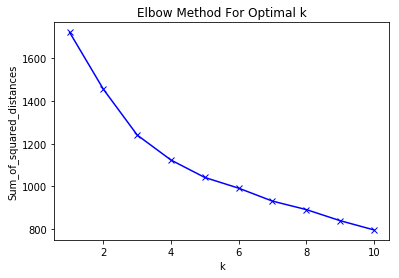

In [137]:
#Find best k value and drop city, lat, lng, and number of visitor so locations are grouped only by venue types
city_grouped_clustering = city_grouped_sum.drop(['City', 'Latitude', 'Longitude', 'Avg Visitors'], axis = 1)
Sum_of_squared_distances = []
K = []
for k in range(1, 11):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0, n_init =12).fit(city_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)
    K.append(k)
    print("k = ", k, "Cost = ", kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [152]:
#Cluster with k = 3 appears to be the elbow
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, init="k-means++", random_state=0, n_init =12).fit(city_grouped_clustering)

# add clustering labels
city_venues_sorted.drop(columns= ['Cluster Labels'], inplace = True)
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

city_venues_sorted.head()

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,Latitude,Longitude,Avg Visitors
0,2,"Atlanta, GA",Park,Market,Farmers Market,Fast Food Restaurant,Baseball Stadium,Football Stadium,Shopping Plaza,Theme Park,...,Mountain,Trail,Theater,Outdoor Sculpture,Movie Theater,Liquor Store,State / Provincial Park,33.749099,-84.390185,722.5
1,2,"Austin, TX",Park,Hotel,Gourmet Shop,Movie Theater,Trail,BBQ Joint,Coffee Shop,Warehouse Store,...,Lake,Bar,Playground,Brewery,Fast Food Restaurant,Golf Driving Range,Food Court,30.271129,-97.743699,275.5
2,2,"Baltimore, MD",Fast Food Restaurant,Supermarket,Wine Shop,Park,Farmers Market,Shopping Mall,Baseball Stadium,Football Stadium,...,General Entertainment,Pizza Place,Sports Bar,Food Court,Food & Drink Shop,Food Truck,Flower Shop,39.284749,-76.620475,167.0
3,2,"Boston, MA",Park,Supermarket,Plaza,Brewery,Shopping Mall,Baseball Stadium,Garden,Bakery,...,Trail,Farmers Market,Beach,Art Museum,Coffee Shop,Food Court,Tapas Restaurant,42.360253,-71.058291,1650.5
4,2,"Buffalo, NY",Supermarket,Park,Scenic Lookout,Café,Waterfall,Football Stadium,Tour Provider,Hockey Arena,...,Arts & Crafts Store,Fast Food Restaurant,Food & Drink Shop,Forest,Dive Spot,Dog Run,Food Truck,42.886717,-78.878392,412.0


In [156]:
#Cluster 0
city_venues_sorted.loc[city_venues_sorted['Cluster Labels'] == 0, city_venues_sorted.columns[[1] + list(range(2, city_venues_sorted.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,Latitude,Longitude,Avg Visitors
32,"New York, NY",Park,Art Museum,Tennis Stadium,Scenic Lookout,Plaza,Bridge,Building,Memorial Site,Church,...,Concert Hall,Fountain,Farmers Market,Farm,Forest,Football Stadium,Food Truck,40.712728,-74.006015,10320.5
33,"Newark, NJ",Park,Tennis Stadium,Art Museum,Scenic Lookout,Plaza,Bridge,Supermarket,Building,Memorial Site,...,Movie Theater,Concert Hall,Fountain,Farmers Market,Food Court,Flower Shop,Food Truck,40.735657,-74.172367,226.5
35,"Oakland, CA",Park,Historic Site,Beach,Trail,Theater,Market,Baseball Stadium,Plaza,Art Museum,...,Movie Theater,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Floating Market,Flower Shop,37.804456,-122.271356,198.5
50,"San Francisco, CA",Park,Beach,Historic Site,Trail,Market,Baseball Stadium,Plaza,Art Museum,Mountain,...,Movie Theater,Scenic Lookout,Floating Market,Football Stadium,Food Truck,Food Court,Food & Drink Shop,37.779026,-122.419906,3482.5
55,"Seattle, WA",Park,Supermarket,Market,Plaza,Stadium,Baseball Stadium,Scenic Lookout,Fish Market,Zoo,...,Sculpture Garden,Canal Lock,Art Museum,Botanical Garden,Concert Hall,Trail,Waterfront,47.603832,-122.330062,730.5


In [157]:
#Cluster 1
city_venues_sorted.loc[city_venues_sorted['Cluster Labels'] == 1, city_venues_sorted.columns[[1] + list(range(2, city_venues_sorted.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,Latitude,Longitude,Avg Visitors
6,"Cape Coral, FL",Warehouse Store,Hotel,Fast Food Restaurant,Hardware Store,Wine Shop,Beach,Shopping Mall,Outlet Mall,Convenience Store,...,Caribbean Restaurant,Ice Cream Shop,Performing Arts Venue,Pizza Place,Sports Bar,Deli / Bodega,Movie Theater,26.605943,-81.980677,277.5
15,"Fort Lauderdale, FL",Shopping Mall,Beach,Hotel,Theme Restaurant,Big Box Store,Warehouse Store,Football Stadium,Resort,Nudist Beach,...,Concert Hall,Wine Shop,Theater,Park,American Restaurant,Food Court,Flower Shop,26.122308,-80.143379,936.0
16,"Hilo, HI",Beach,Scenic Lookout,Coffee Shop,Hardware Store,Park,Pharmacy,Big Box Store,Supermarket,State / Provincial Park,...,Farmers Market,Flea Market,Flower Shop,Other Great Outdoors,Candy Store,Hawaiian Restaurant,Breakfast Spot,19.707243,-155.081635,254.0
17,"Honolulu, HI",Shopping Mall,Hotel,Beach,Resort,Park,Nature Preserve,Farm,Department Store,Food Court,...,Fast Food Restaurant,Food & Drink Shop,Flower Shop,Floating Market,Hotel Pool,Flea Market,Fish Market,21.304547,-157.855676,2632.5
21,"Kahului, HI",Resort,Hotel,Surf Spot,Beach,Seafood Restaurant,Farm,American Restaurant,Aquarium,Scenic Lookout,...,Miscellaneous Shop,Convenience Store,Pizza Place,Hawaiian Restaurant,Harbor / Marina,Food & Drink Shop,Food Court,20.874771,-156.452983,263.5
22,"Kapaa, HI",Hotel,Beach,Shopping Mall,Seafood Restaurant,Resort,Pharmacy,Waterfall,Warehouse Store,Scenic Lookout,...,Hotel Pool,Floating Market,Farmers Market,Flea Market,Fish Market,Flower Shop,Food & Drink Shop,22.083340,-159.346352,98.5
23,"Key West, FL",Hotel,Bar,Seafood Restaurant,Beach,Plaza,State / Provincial Park,Pharmacy,Pool,History Museum,...,Coffee Shop,Pizza Place,Outdoors & Recreation,Dive Spot,Breakfast Spot,Historic Site,Farm,24.562557,-81.772437,476.0
24,"Las Vegas, NV",Casino,Shopping Mall,Resort,Hotel,Racetrack,Nightclub,Nature Preserve,Fountain,Pedestrian Plaza,...,Theme Park Ride / Attraction,Trail,Tourist Information Center,Golf Driving Range,Burger Joint,Hardware Store,Field,36.167256,-115.148516,3020.0
25,"Los Angeles, CA",Beach,Theme Park Ride / Attraction,Shopping Mall,Park,Hotel,Museum,Theme Park,Shopping Plaza,Fountain,...,Market,Farmers Market,College Residence Hall,Music Venue,Art Museum,Warehouse Store,Trail,34.053691,-118.242767,4919.5
27,"Miami, FL",Shopping Mall,Park,Beach,Hotel,Resort,Warehouse Store,Basketball Stadium,Football Stadium,Art Gallery,...,Dive Spot,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Floating Market,Flea Market,25.774266,-80.193659,5119.0


In [158]:
#Cluster 2
city_venues_sorted.loc[city_venues_sorted['Cluster Labels'] == 2, city_venues_sorted.columns[[1] + list(range(2, city_venues_sorted.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,Latitude,Longitude,Avg Visitors
0,"Atlanta, GA",Park,Market,Farmers Market,Fast Food Restaurant,Baseball Stadium,Football Stadium,Shopping Plaza,Theme Park,Aquarium,...,Mountain,Trail,Theater,Outdoor Sculpture,Movie Theater,Liquor Store,State / Provincial Park,33.749099,-84.390185,722.5
1,"Austin, TX",Park,Hotel,Gourmet Shop,Movie Theater,Trail,BBQ Joint,Coffee Shop,Warehouse Store,Racetrack,...,Lake,Bar,Playground,Brewery,Fast Food Restaurant,Golf Driving Range,Food Court,30.271129,-97.743699,275.5
2,"Baltimore, MD",Fast Food Restaurant,Supermarket,Wine Shop,Park,Farmers Market,Shopping Mall,Baseball Stadium,Football Stadium,Furniture / Home Store,...,General Entertainment,Pizza Place,Sports Bar,Food Court,Food & Drink Shop,Food Truck,Flower Shop,39.284749,-76.620475,167.0
3,"Boston, MA",Park,Supermarket,Plaza,Brewery,Shopping Mall,Baseball Stadium,Garden,Bakery,Historic Site,...,Trail,Farmers Market,Beach,Art Museum,Coffee Shop,Food Court,Tapas Restaurant,42.360253,-71.058291,1650.5
4,"Buffalo, NY",Supermarket,Park,Scenic Lookout,Café,Waterfall,Football Stadium,Tour Provider,Hockey Arena,State / Provincial Park,...,Arts & Crafts Store,Fast Food Restaurant,Food & Drink Shop,Forest,Dive Spot,Dog Run,Food Truck,42.886717,-78.878392,412.0
5,"Cambridge, MA",Park,Supermarket,Plaza,Brewery,Shopping Mall,Baseball Stadium,Bakery,Garden,Historic Site,...,Trail,Farmers Market,Art Museum,Coffee Shop,Food Court,Tapas Restaurant,Hotel,42.375100,-71.105616,108.5
7,"Charlotte, NC",Fast Food Restaurant,Warehouse Store,Park,Market,Theme Park,Shopping Mall,Football Stadium,Furniture / Home Store,Basketball Stadium,...,Sporting Goods Shop,Convenience Store,Baseball Stadium,Seafood Restaurant,Rafting,Brewery,General Entertainment,35.227087,-80.843127,186.5
8,"Chicago, IL",Park,Hotel,Zoo,Electronics Store,Other Great Outdoors,Baseball Stadium,Stadium,Waterfront,Tour Provider,...,Theater,Gourmet Shop,History Museum,Beach,Scenic Lookout,Science Museum,Harbor / Marina,41.875562,-87.624421,1530.5
9,"Cincinnati, OH",Supermarket,Park,Brewery,Trail,Community Center,Baseball Stadium,Warehouse Store,Zoo,Music Venue,...,Bagel Shop,Food & Drink Shop,History Museum,Ice Cream Shop,Fast Food Restaurant,Golf Driving Range,Hotel,39.101454,-84.512460,102.5
10,"Cleveland, OH",Park,Warehouse Store,National Park,Shopping Mall,Movie Theater,Baseball Stadium,Farmers Market,Zoo,Basketball Stadium,...,Market,Hotel,Burger Joint,Wings Joint,Art Museum,Taco Place,Brewery,41.505161,-81.693445,120.5


In [145]:
city_venues_sorted.groupby(by = "Cluster Labels").mean()['Avg Visitors']

Cluster Labels
0    2991.7
1    1360.0
2     420.5
Name: Avg Visitors, dtype: float64

In [149]:
#Map clusters
#create map
kcluster = 3
map_clusters = folium.Map(location=[48, -102], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_venues_sorted['Latitude'], city_venues_sorted['Longitude'], city_venues_sorted['City'], city_venues_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

This map demonstrates how certian clusters may be specific to the cities location. For example, cluster 1 (purple) tends to be located solely on the coastline in Florida and California. This information is useful, because it indicates that venue types such as surf spots, piers, and beaches may be only available in these types of city environments. Cluster 2 is scattered across the US where none of the other clusters tend to enter. 


Cluster Labels Avg Visitors
* 0:  2991.7
* 1:  1360.0
* 2:  420.5

## Results <a name="results"></a>

Analysis of the venue type’s impact on international visitation demonstrated four venue types (Fountain, Tennis Stadium, Memorial Site, and Art Museum) that have a moderate positive correlation with strong certainty, nine venue types (Theme Park, Bridge, Public Art, Park, Performing Arts Venue, Canal, College Residence Hall, Observatory, and Building) that have a moderate positive correlation with moderate certainty, two venue types (Monument/Landmark and Art Gallery) that have a weak positive correlation with moderate certainty, one venue type (Shopping Mall) that has a weak positive correlation with weak certainty, and three venue types (Fast Food Restaurant, American Restaurant, and Warehouse Store) that have a weak negative correlation with weak certainty. 

Further explorative analysis demonstrates that Parks are the most common type of venue among all cities with 20 cities having Park as the most common venue type, 10 cities having Park as the second most common venue type, and 4 cities having Park as the third most common venue type.  

Clustering cities by the popularity of venue types within each city and calculating the inertia of each kmeans value demonstrated the optimal number of clusters was three. After grouping the cities into three clusters and remapping them with cluster labels on a United States map, it is clear that the geographical location of the city plays an important role in the types of common venues in each city. Cluster 0 contains cities that have common venue types of Park, Scenic Lookout, Trails, and Plaza and cities in this cluster have an average of 2,991,000 visitors per year. Cluster 1 cities have common venue types of Beach, Surf Spot, and Hotel and cities in this cluster have an average of 1,360,000 visitors per year. Cluster 2 contains cities with common venue types of Park, Warehouse Store, Supermarkets, and Fast Food Restaurants and cities in this cluster have an average of 420,000 visitors per year.


## Discussion <a name="discussion"></a>

International tourism is an important aspect of the United States economy and understanding the factors that influence tourism rates is important. The type of venues that are located within United States cities play a significant role on the rate of international tourism. It was determined that fountains, tennis stadiums, memorial sites, and art museums have the greatest positive correlation to international tourism rates with strong certainty. In which case, it would be in governing bodies best interest to build these types of venues in cities throughout the United States. In addition, fast food restaurants, american restaurants, and warehouse stores have a negative correlation to international tourism rates, and thus, should not be implemented into city building plans.
	
It was visualized that the geographical location of cities has a major impact on the type of venues that are commonly present. Cities close to the coastline tend to have more coastline specific venues such as beaches, surf spots, and resort hotels. Cities near mountain ranges and forests tend to have popular venues such as parks, science lookouts, and trails. Clustered cities that were scattered across the United States more commonly had venues such as parks, warehouse stores, supermarkets, and fast food restaurants. Using this information, legislators can also consider the geographical location of each city to consider which venue types may be more successful. In these cases, if a city is located near the coastline it would be most beneficial to create public beaches and surf spots. Inland cities would benefit most by building parks, art museums, and fountains while reducing the number of fast food restaurants and warehouse stores.
	
Further evaluation and consideration of the data indicates some potential flaws with various venue types. There were only four tennis stadiums total, and one was from New York, NY, which has the highest international tourism rate among all cities. In this case, the perception of tennis stadiums impact on international tourism rates may be relatively skewed. However, if available, future research can utilize Foursquare “checkincounts” to create a more accurate weight based on the popularity of each venue type. A more accurate correlation between each venue type and international tourism rate could then be obtained. Also, venue data specific to international tourism would help isolate the types of venues that are more important to promoting international tourism. Foursquare offers only data on the popularity of various venues, and since it is likely that international travelers don’t visit all locations that local residents frequent, such as gyms and grocery stores, more specific data would provide a stronger correlation between venue type and international tourism rate. In addition, memorial sites have an interesting influence on international tourism rates. It is likely that the importance and connection of the memorial site to international tourists plays a significant role on how popular each site would be in attracting tourists. Also, many cities do not have memorial sites simply because there is no historical moment that is significant enough to build a memorial site within the respective city. In these cases, it may be important to consider a historical lens, and not the type of venues, when determining the popularity of international tourism within United States cities. For example, when comparing the 9/11 Memorial Pool in New York, NY to other memorial sites a historical lens may be more important than simply looking at the venue type when determining a memorial sites impact on international tourism. Future research can also further this research by determining areas that are likely to be visited by tourists in one trip. This would be important to consider because if two locations are closely located, than their popular venues would also likely have an impact on each individual cities international travel rates.



## Conclusion <a name="conclusion"></a>

International tourism is an important aspect of the United States economy and understanding the factors that influence tourism can benefit United States economies, job production, and conservation of many historical and environmental sites. Legislators should focus on building fountains, parks, art museums, theme parks, and bridges while reducing the number of fast food restaurants, american restaurants, and warehouse stores in United States cities to promote international tourism while also carefully considering the geographical aspects of each city.